# Naive Bayes — Scikit-Learn

Two-part pipeline showcasing both Naive Bayes variants:

**Part 1: GaussianNB** (Breast Cancer — binary classification baseline)
- 569 samples, 30 continuous features, 2 classes (malignant/benign)
- Assumes features follow Gaussian distributions within each class

**Part 2: MultinomialNB** (20 Newsgroups — text classification main event)
- 11,314 train / 7,532 test documents, 10,000 TF-IDF features, 20 categories
- Classic NB benchmark — high-dimensional sparse text is where NB shines

**Showcase**: `CalibratedClassifierCV` — Platt scaling to fix NB's poor probability calibration.

In [1]:
import sys
import os
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Add project root to path for utils
sys.path.insert(0, os.path.abspath('../..'))
from utils.data_loader import load_processed_data
from utils.performance import track_performance, track_inference, get_model_size
from utils.metrics import evaluate_classifier, print_metrics
from utils.visualization import (plot_calibration_curve, plot_confusion_matrix,
                                  plot_confusion_matrix_multiclass, plot_per_class_f1)
from utils.results import save_results, add_result, print_comparison

# Configuration
RANDOM_STATE = 113
ALPHA = 1.0            # Laplace smoothing parameter
FRAMEWORK = 'Scikit-Learn'

# Load both datasets
X_train_g, X_test_g, y_train_g, y_test_g, meta_g = load_processed_data('naive_bayes_gaussian')
X_train_t, X_test_t, y_train_t, y_test_t, meta_t = load_processed_data('naive_bayes_text')

print("=" * 60)
print(f"NAIVE BAYES — {FRAMEWORK}")
print("=" * 60)
print(f"\nPart 1: Breast Cancer (GaussianNB)")
print(f"  Training: {X_train_g.shape[0]} samples, {X_train_g.shape[1]} features")
print(f"  Test:     {X_test_g.shape[0]} samples")
print(f"  Classes:  {meta_g['n_classes']} ({meta_g['class_names']})")
print(f"\nPart 2: 20 Newsgroups (MultinomialNB)")
print(f"  Training: {X_train_t.shape[0]:,} samples, {X_train_t.shape[1]:,} features")
print(f"  Test:     {X_test_t.shape[0]:,} samples")
print(f"  Classes:  {meta_t['n_classes']} categories")

NAIVE BAYES — Scikit-Learn

Part 1: Breast Cancer (GaussianNB)
  Training: 455 samples, 30 features
  Test:     114 samples
  Classes:  2 (['malignant', 'benign'])

Part 2: 20 Newsgroups (MultinomialNB)
  Training: 11,314 samples, 10,000 features
  Test:     7,532 samples
  Classes:  20 categories


In [2]:
# Step 1: Train GaussianNB on breast cancer
"""
GaussianNB assumes each feature follows a gaussian (normal) distribution
within each class. No hyperparameters to tune - just fit and predict.
"""
gnb = GaussianNB()
gnb.fit(X_train_g, y_train_g)

# Predictions + probabilities for both sets
train_pred_g = gnb.predict(X_train_g)
test_pred_g = gnb.predict(X_test_g)
train_proba_g = gnb.predict_proba(X_train_g)[:, 1]  # P(benign) for binary
test_proba_g = gnb.predict_proba(X_test_g)[:, 1]

# Streamlined evaluation — auto-detects binary, includes probabilistic metrics
train_metrics_g = evaluate_classifier(y_train_g, train_pred_g, train_proba_g)
test_metrics_g = evaluate_classifier(y_test_g, test_pred_g, test_proba_g)
print_metrics(train_metrics_g, test_metrics_g, title='GaussianNB — Breast Cancer')


METRICS — GaussianNB — Breast Cancer
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.9385       0.8947
precision                       0.9509       0.9054
recall                          0.9509       0.9306
f1                              0.9509       0.9178
auc                             0.9591       0.9363
log_loss                        0.7158       1.0123
brier_score                     0.0608       0.0983
ece                             0.3703       0.3590


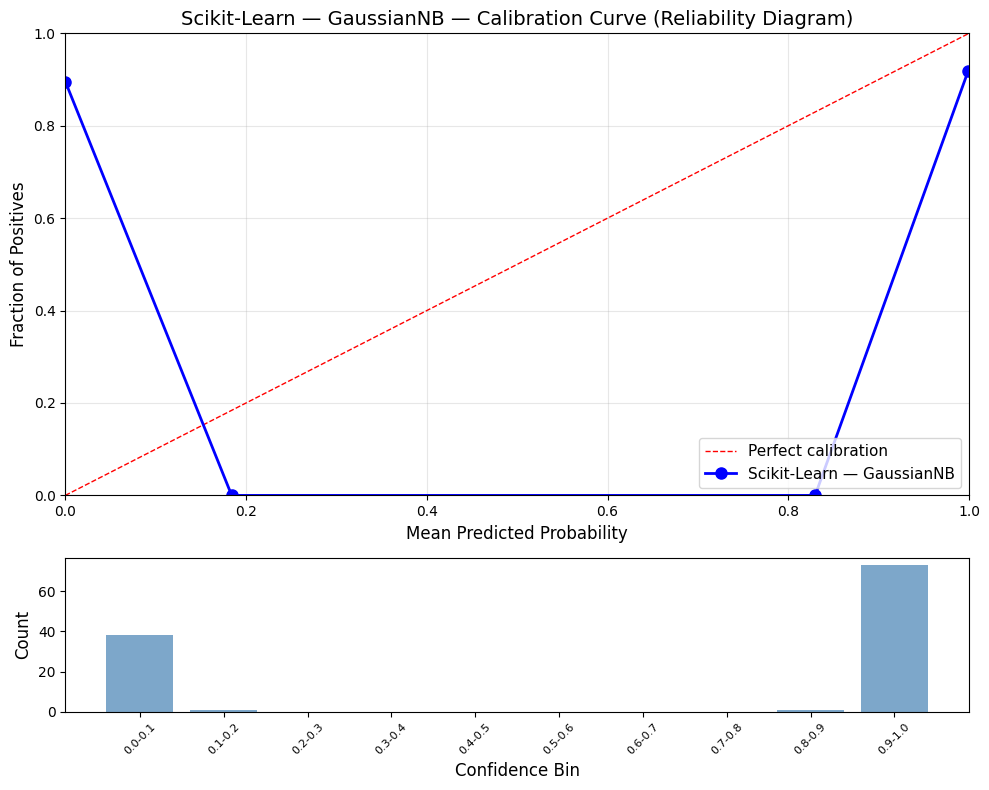

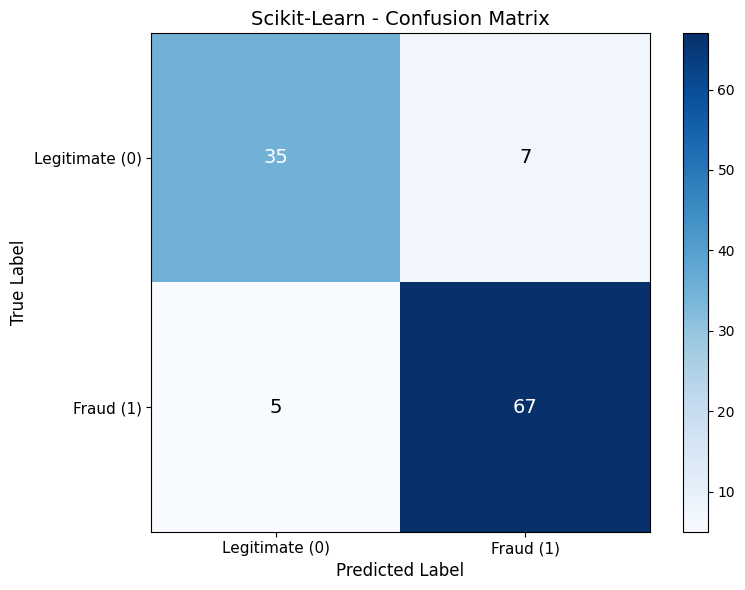

GaussianNB baseline complete.
Key takeaway: 89.5% accuracy but ECE=0.3590 — poorly calibrated.


In [4]:
# Step 2: GaussianNB visualizations
"""
Calibration curve shows how poorly calibrated NB probabilities are - 
ECE of 0.359 means predictions are significantly overconfident
"""
plot_calibration_curve(y_test_g, gnb.predict_proba(X_test_g)[:, 1],
                       f'{FRAMEWORK} — GaussianNB', save_path='results/gaussian_calibration.png')

plot_confusion_matrix(y_test_g, test_pred_g, FRAMEWORK,
                      save_path='results/gaussian_confusion_matrix.png')

print(f"GaussianNB baseline complete.")
print(f"Key takeaway: 89.5% accuracy but ECE={test_metrics_g['ece']:.4f} — poorly calibrated.")